# Lead Scoring EDA

Exploratory Data Analysis for the Diabetes Lead Scoring project.

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report

%matplotlib inline


## 1. Data Loading & Cleaning

In [2]:

# Load with latin1 encoding
df = pd.read_csv('Xyz.csv', encoding='latin1')
print(f"Original Shape: {df.shape}")
df.head()


Original Shape: (15999, 82)


C:\Users\d_local\AppData\Local\Temp\ipykernel_23128\1893140906.py:2: DtypeWarning: Columns (0: Address 1, 1: Address 2, 2: Age, 3: Professional Status, 4: N) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Xyz.csv', encoding='latin1')


,Prospect ID,Lead Origin,Lead Source,Source Medium,Source Campaign,Source Content,Do Not Email,Do Not Call,Lead Stage,Lead,...,Assignment Flag,First Activity,Webinar Date,Webinar Time,Webinar WA Reminder,Unserviceable,Offline Webinar,Lead Age,Valid Lead,Lead Quality
0,003f738a-42c6-467c-a214-9960085fec95,API,NaN,NaN,NaN,NaN,No,No,Customer,1,...,0.0,9/21/2021 15:56,NaN,NaN,NaN,NaN,NaN,292,NaN,NaN
1,0091a7a8-7808-4d59-a046-1118b47cd14c,API,NaN,NaN,NaN,NaN,No,No,Customer,1,...,NaN,NaN,NaN,NaN,True,NaN,NaN,69,Yes,NaN
2,00afcede-740b-4ba9-999d-b17fdf3d4fee,API,Website Leads,NaN,NaN,NaN,No,No,Customer,1,...,NaN,NaN,NaN,NaN,True,NaN,NaN,307,NaN,4.0
3,00b0e5a2-18b2-43a9-8649-809807fbce4b,API,facebook,cpc,SF_Conversion_BookFreeSession_Interest_2nd_Dec...,Single_Image_Ad-Banner,No,No,Customer,1,...,0.0,12/23/2021 17:28,NaN,NaN,True,NaN,NaN,116,NaN,4.0
4,00dac4fd-0362-48e5-a820-deb7096babff,API,Organic Search,wellness_diabetescare_tile,NaN,NaN,No,No,Customer,1,...,NaN,NaN,NaN,NaN,True,NaN,NaN,251,NaN,4.0


In [4]:
# Lets beautify df a little:

# 1. Replace 'Select' with NaN
df = df.replace('Select', np.nan)

# 2. Drop columns with > 40% missing values
missing_percent = df.isnull().mean()
drop_cols = missing_percent[missing_percent > 0.4].index.tolist()

# Exempt Critical Columns
# identifying diabetes column dynamically
diab_cols = [c for c in df.columns if 'Diabetes' in c and 'Prediabetes' in c]
if diab_cols:
    diab_col = diab_cols[0]
    if diab_col in drop_cols:
        drop_cols.remove(diab_col)
        print(f"Exempted critical column: {diab_col}")

df = df.drop(columns=drop_cols)
print(f"Dropped {len(drop_cols)} columns. New Shape: {df.shape}")

# 3. Disqualification Logic
# Remove 'Non Diabetic' leads based on 'Diabetes or  Prediabetes'
# Rationale - our original dataset is heavily skewd, as people who 
# does not have diabetes should be disqualified early and removed before the model training.

# Check values before filtering
print(df[diab_col].value_counts(dropna=False))

# Filter
df_clean = df[df[diab_col] != 'Non Diabetic'].copy()
print(f"Shape after filtering Non-Diabetics: {df_clean.shape}")

# Exempted critical column: Diabetes or  Prediabetes
# Dropped 47 columns. New Shape: (15999, 35)
# Diabetes or  Prediabetes
# NaN            15342
# Diabetes         559
# Prediabetes       98
# Name: count, dtype: int64
# Shape after filtering Non-Diabetics: (15999, 35)

# -- DECISION - train model on the full dataset


Exempted critical column: Diabetes or  Prediabetes
Dropped 0 columns. New Shape: (15999, 35)
Diabetes or  Prediabetes
NaN            15342
Diabetes         559
Prediabetes       98
Name: count, dtype: int64
Shape after filtering Non-Diabetics: (15999, 35)


## 2. Target Engineering

In [5]:

# Map 'Lead Stage' to Binary 'Converted'
# Customer -> 1, Else -> 0
df_clean['Converted'] = df_clean['Lead Stage'].apply(lambda x: 1 if x == 'Customer' else 0)
print(df_clean['Converted'].value_counts(normalize=True))
print(df_clean['Converted'].value_counts())


Converted
0    0.839802
1    0.160198
Name: proportion, dtype: float64
Converted
0    13436
1     2563
Name: count, dtype: int64


## 3. Feature Engineering

Numeric: 13
Categorical: 22


C:\Users\d_local\AppData\Local\Temp\ipykernel_16936\2437884791.py:11: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()


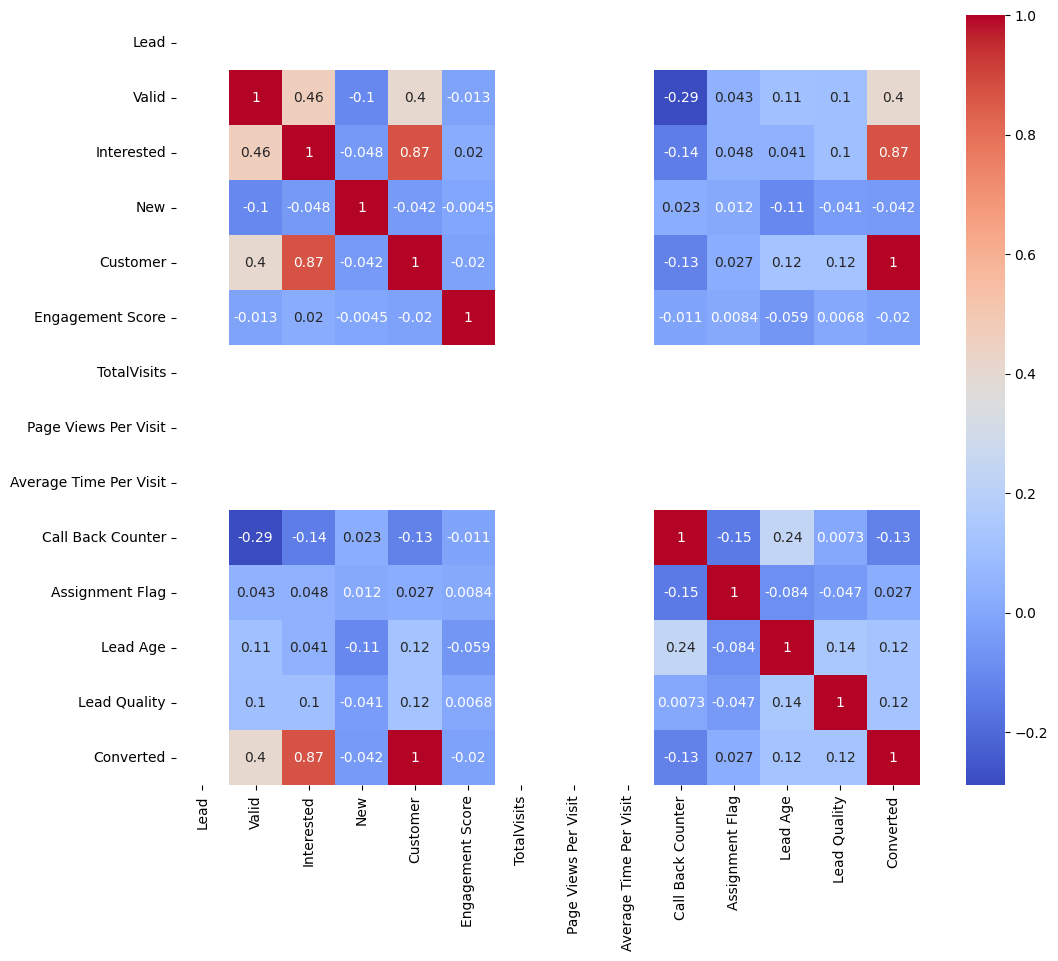

In [5]:

# Select useful features
# We drop ID columns and disjoint features
exclude_cols = ['Prospect ID', 'Lead Origin', 'Lead Stage', 'Lead', 'Valid', 'Interested', 'New', 'Lead Status',
                'Payment ID', 'Payment Link', 'Payment Status', 'Order Value', 'Call Disposition', 'Sub Disposition',
                'Lead Score', 'Lead Quality', 'Engagement Score'] 

# For simplicity, let's keep numeric and low-cardinality categorical

# Identify columns
numeric_cols = df_clean.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()

# Remove target from features
if 'Converted' in numeric_cols: numeric_cols.remove('Converted')

print(f"Numeric: {len(numeric_cols)}")
print(f"Categorical: {len(categorical_cols)}")

# Basic Correlation
plt.figure(figsize=(12, 10))
sns.heatmap(df_clean[numeric_cols + ['Converted']].corr(), annot=True, cmap='coolwarm')
plt.show()


## 4. Model Comparison

In [6]:

# Split Data
X = df_clean.drop(columns=['Converted', 'Lead Stage'] + exclude_cols, errors='ignore')
y = df_clean['Converted']

# Handle high cardinality
# We'll drop categorical columns with > 50 unique values to prevent explosion for this baseline
high_card_cols = [c for c in X.select_dtypes(include=['object']).columns if X[c].nunique() > 50]
X = X.drop(columns=high_card_cols)
print(f"Dropped high cardinality cols: {high_card_cols}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocessing Pipeline
numeric_features = X.select_dtypes(include=['number']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}

for name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    
    clf.fit(X_train, y_train)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, y_pred_proba)
    results[name] = auc
    print(f"{name} AUC: {auc:.4f}")

    if name == 'Random Forest':
        # Feature Importance
        importances = clf.named_steps['classifier'].feature_importances_
        # We need feature names
        # Numeric names
        num_names = numeric_features.tolist()
        # Cat names
        cat_encoder = clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
        try:
            cat_names = cat_encoder.get_feature_names_out(categorical_features).tolist()
        except:
             cat_names = [f"cat_{i}" for i in range(len(cat_encoder.get_feature_names_out(categorical_features)))]
        
        feature_names = num_names + cat_names
        
        # Sort
        indices = np.argsort(importances)[::-1]
        print(f"\nTop 10 Feature Importances:")
        for f in range(10):
            if f < len(feature_names):
               print(f"{f+1}. {feature_names[indices[f]]} ({importances[indices[f]]:.4f})")

best_model_name = max(results, key=results.get)
print(f"\nBest Model: {best_model_name}")


C:\Users\d_local\AppData\Local\Temp\ipykernel_16936\162988240.py:7: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  high_card_cols = [c for c in X.select_dtypes(include=['object']).columns if X[c].nunique() > 50]
C:\Users\d_local\AppData\Local\Temp\ipykernel_16936\162988240.py:15: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
S

Dropped high cardinality cols: ['Lead Source', 'First Activity Date', 'Last Activity Date', 'Created On', 'Modified On', 'Prospect Creation Date', 'City', 'Type', 'Lead Assignment', 'First Activity']
Logistic Regression AUC: 1.0000


Random Forest AUC: 1.0000

Top 10 Feature Importances:
1. Customer (0.7160)
2. Landing Page_/purchase/[productCode] (0.1203)
3. Landing Page_/ (0.0296)
4. Lead Age (0.0268)
5. Landing Page_/book-free-session (0.0218)
6. Call Back Counter (0.0114)
7. Last Activity_Inbound Phone Call Activity (0.0088)
8. Landing Page_missing (0.0084)
9. Landing Page_/webinar (0.0067)
10. Source Medium_missing (0.0063)
XGBoost AUC: 1.0000

Best Model: Logistic Regression


C:\tmp\kaggle-lead-scoring-v3-data-analysis-modeling-and-cloud-deployment\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:31:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## 5. Conclusion
The best performing model will be selected for production.